In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.graphs_config import ABC_3
from utils.functions import fit_step_titanic, calc_accuracy_titanic, update_params_titanic
from networks.logreg_model_titanic import LogRegTitanic

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

In [2]:
topology = ABC_3
n_agents = len(topology)

In [3]:
dataset_name = 'titanic'

In [4]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    indices = [i for i in range(len(trainset))]
    np.random.shuffle(indices)
    indices = indices[:n_agents*(len(trainset) // n_agents)]
    indices = np.array_split(indices, n_agents)
    subsets = [torch.utils.data.Subset(trainset, indices=ind) for ind in indices]
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

elif dataset_name == 'titanic':
    def prepare_dataset(df):
        df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
        df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
        df = df.fillna({'Age': df['Age'].mean()})
        df['Age'] /= 100
        df['Fare'] /= 100
        df['_bias'] = 1
        if 'Survived' in df.columns:
            return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
        else:
            return df
    
    train_data = pd.read_csv('../data/titanic/train.csv')
    train_features, train_answers = prepare_dataset(train_data)

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
    X = train_features[features].to_numpy()
    y = train_answers.to_numpy()

    common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
    X_train, y_train = X[X.shape[0] // 10:], y[X.shape[0] // 10:]
    
    X_train_parts = np.array_split(X_train, n_agents)
    y_train_parts = np.array_split(y_train, n_agents)
    
    train_loaders = {node_name: [(x, y)] for node_name, x, y in zip(topology, X_train_parts, y_train_parts)}
    test_loader = (common_test_X, common_test_y)
else:
    print("This dataset is not yet supported.")
    exit(0)

In [5]:
stat_step  = 200
num_epochs = 20000
epoch_len  = 1

In [6]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    fit_step=fit_step_titanic,
                    update_params=update_params_titanic,
                    calc_accuracy=calc_accuracy_titanic,
                    stat_step=stat_step, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    update_params_epoch_start=1, # the first epoch from which consensus begins
                    update_params_period=1, # consensus iteration period
                    verbose=0 # verbose mode
                   )

In [7]:
model = LogRegTitanic
model_args = [X.shape[1]]

In [8]:
master.set_model(model, *model_args)

In [9]:
master.initialize_nodes()

In [10]:
master.start_consensus()
print("Done!")

Master started

Master ended in 9.84 sec

Done!


In [11]:
master.network['Alice'].model.W

array([-0.3368269 , -0.94907853,  0.02238781, -0.10550813,  0.03958138,
        0.40976423,  0.24278197])

In [12]:
master.network['Bob'].model.W

array([-0.33683236, -0.94907429,  0.02238937, -0.10551006,  0.03957921,
        0.40976674,  0.24278426])

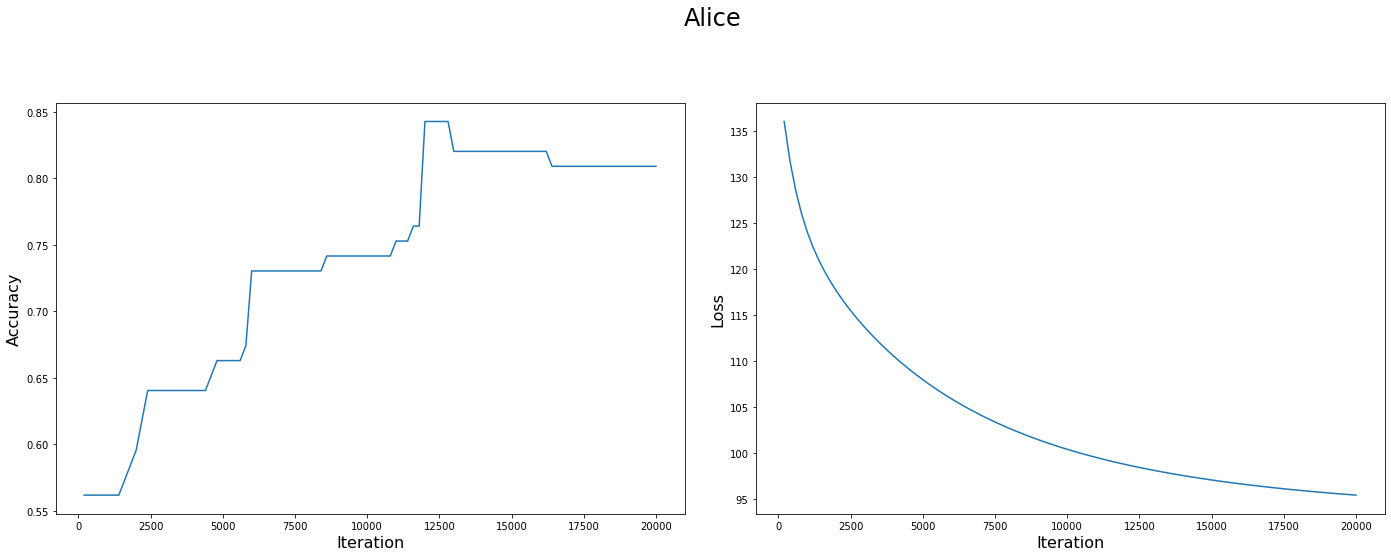

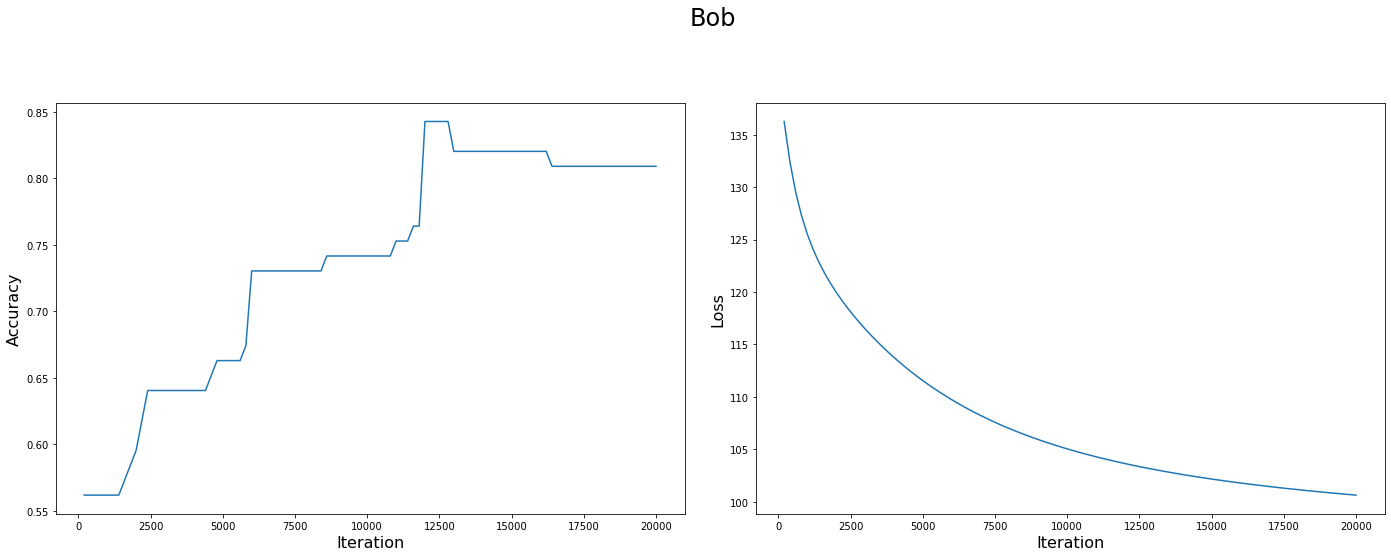

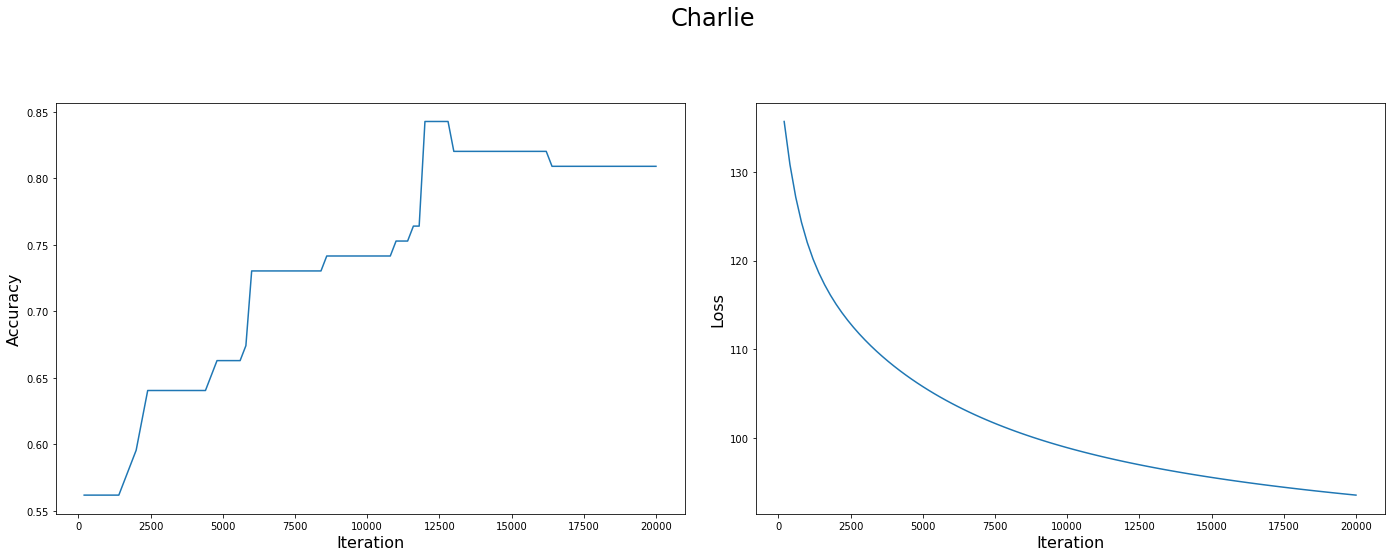

In [13]:
# Accuracy and loss plots for each node
for node in master.network.values():
    node.show_graphs()